In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

In [2]:
import pingouin as pg
import scipy.stats as ss
import statsmodels.formula.api as smf

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.api import anova_lm

Итак, первая задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

A – прямоугольные 16:9
B – квадратные
C – прямоугольные 12:4

### ANOVA

Проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

scipy.stats.levene либо pingouin.homoscedasticity

In [3]:
data_1 = pd.read_csv('5_task_1.csv')

In [4]:
data_2 = pd.read_csv('5_task_2.csv')

In [5]:
data_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [6]:
data_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [7]:
pg.homoscedasticity(data_1, dv="events", group="group")

,W,pval,equal_var
levene,2.26226,0.104133,True


### p-value > 0.05, не отклоняем нулевую гипотезу

Также убедимся, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность обязательно сделаем семплирование 
(1000 наблюдений), так как на больших выборках могут получаться неверные результаты.
Для воспроизводимости результата используем параметр random_state=17 в методе sample.

Дополнительно: попробуем посчитать тест Шапиро-Уилка без использования метода sample. 
Сравним результат с normaltest, а также qq-графиками.

In [8]:
data_sample = data_1.sample(1000, random_state=17)

In [9]:
data_sample.head()

,id,group,events
15854,13314,B,35
7388,28016,A,24
1799,3329,A,30
735,27540,A,31
22485,16435,C,28


In [10]:
ss.shapiro(data_sample.events)

ShapiroResult(statistic=0.995732307434082, pvalue=0.007103940937668085)

In [11]:
ss.shapiro(data_sample.query('group == "A"').events)

ShapiroResult(statistic=0.9929315447807312, pvalue=0.1330225169658661)

In [12]:
ss.shapiro(data_sample.query('group == "B"').events)

ShapiroResult(statistic=0.9900172352790833, pvalue=0.027956675738096237)

In [13]:
ss.shapiro(data_sample.query('group == "C"').events)

ShapiroResult(statistic=0.9954989552497864, pvalue=0.39249300956726074)

In [14]:
ss.shapiro(data_1.query('group == "A"').events)

/Users/denis/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9989418387413025, pvalue=4.318870651331963e-06)

In [15]:
ss.shapiro(data_1.query('group == "B"').events)

ShapiroResult(statistic=0.9990161061286926, pvalue=1.0504894817131571e-05)

In [16]:
ss.shapiro(data_1.query('group == "C"').events)

ShapiroResult(statistic=0.9989210963249207, pvalue=3.3885160064528463e-06)

In [17]:
shapiro_normal = ss.shapiro(data_1.events)

In [18]:
shapiro_normal

ShapiroResult(statistic=0.9992582201957703, pvalue=5.250621049057713e-10)

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

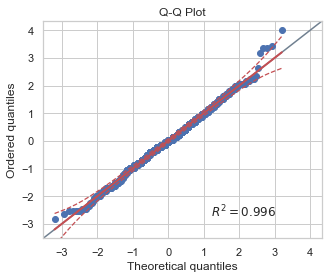

In [19]:
pg.qqplot(data_sample.events)

<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

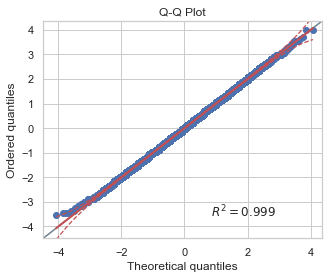

In [20]:
pg.qqplot(data_1.events)

Для сравнения средних я использую 
ОДНОФАКТОРНЫЙ ДИСПЕРСИОННЫЙ АНАЛИЗ. Значение статистики равно (окр. до целого) 
2886, а р-уровень значимости составил 0.

In [21]:
pg.anova(data=data_1, dv="events", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


Теперь используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 

Дополнительно: попробуйте другие варианты поправок на множественные сравнения через pingouin. Дают ли они те же выводы, что и Тьюки?

In [22]:
print(pairwise_tukeyhsd(data_1.events, data_1.group))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034  -0.0   7.7038  8.3642   True
     A      C  -2.1093  -0.0  -2.4395 -1.7791   True
     B      C -10.1433  -0.0 -10.4735 -9.8131   True
----------------------------------------------------


In [23]:
pg.pairwise_tukey(data=data_1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.0,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.0,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.0,1.018089


In [24]:
pg.pairwise_gameshowell(data=data_1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,0.0,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,0.0,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.0,1.024138


Text(0, 0.5, 'Count purchases')

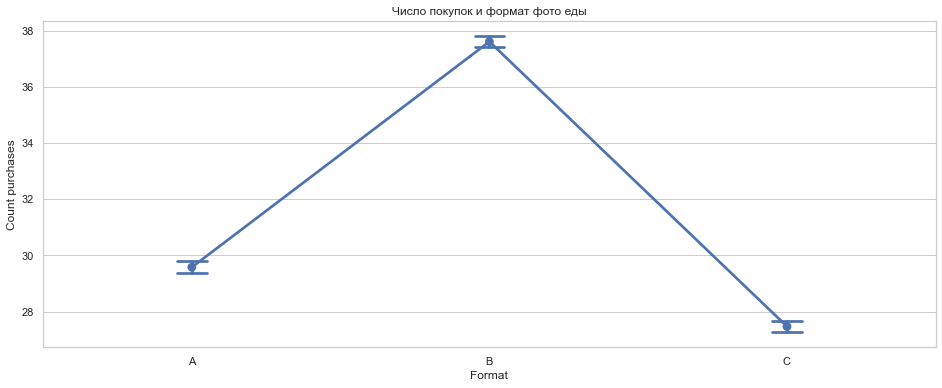

In [25]:
sns.pointplot(x = 'group', y='events', data = data_1, capsize = .1) 
plt.title("Число покупок и формат фото еды")
plt.xlabel('Format')
plt.ylabel('Count purchases')

Посмотрим на данные. Для начала визуализируйте распределение events для контрольной и тестовой групп. Соотнесите графики распределения и экспериментальные группы:

In [26]:
data_test = data_2.query("group =='test'")

In [27]:
data_control = data_2.query("group =='control'")

/Users/denis/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='events'>

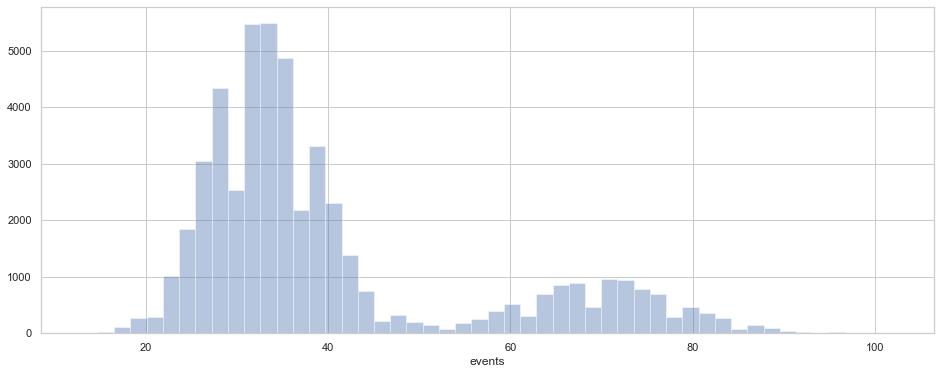

In [28]:
sns.distplot(data_test.events, kde = False)

<AxesSubplot:xlabel='events'>

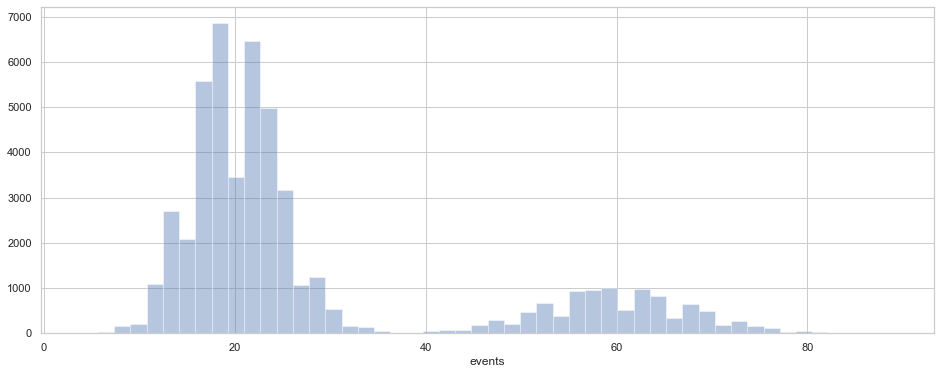

In [29]:
sns.distplot(data_control.events, kde = False)

Посчитайте среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

В качестве ответа укажите стандартное отклонение для пользователей из сегмента high и контрольной группы, с точностью до 2 знаков после точки.



In [30]:
data_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [31]:
data_2.groupby(['group', 'segment']).events.describe().T.round(2)

group     control                test          
segment      high       low      high       low
count    10000.00  40000.00  10000.00  40000.00
mean        59.97     20.03     69.94     33.03
std          7.81      4.47      8.40      5.72
min         31.00      4.00     40.00     13.00
25%         55.00     17.00     64.00     29.00
50%         60.00     20.00     70.00     33.00
75%         65.00     23.00     76.00     37.00
max         89.00     41.00    102.00     59.00

Проведите тест (через anova_lm либо pg.anova), а затем используйте критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.



In [32]:
pg.anova(data=data_2, dv="events", between=["group", "segment"], ss_type=2)  

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


In [33]:
model_interact = smf.ols('events ~ segment + group + segment:group', data=data_2).fit()
anova_lm(model_interact, typ=2)

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377485,0.000000e+00
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [34]:
model_interact = smf.ols("events ~ C(group)*C(segment)", data=data_2).fit()
anova_lm(model_interact, type=2)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
C(segment),1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
C(group):C(segment),1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


В данном случае для последующих сравнений между группами можно проделать следующую операцию: соединить колонки group и segment в combination, чтобы потом передать в аргумент groups в MultiComparison либо pairwise_tukey:

In [35]:
data_2['combination'] = data_2['group'] + '/' +  data_2['segment']

In [36]:
data_2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test/high
1,96723,test,high,71.0,test/high
2,68719,test,high,80.0,test/high
3,50399,test,high,80.0,test/high
4,95613,test,high,78.0,test/high


- **Как по таблице понять, где различия значимые?**
    
    Смотрим на столбец **reject**. Если там стоит True - различия значимые.
    
- **Как по таблице понять характер различий в средних?**
    
    Столбец **meandiff** отражает различие в средних между **второй и первой группой, именно в таком порядке.**

In [37]:
test = (pairwise_tukeyhsd(data_2.events, data_2.combination)).summary()

In [38]:
test

group1,group2,meandiff,p-adj,lower,upper,reject
control/high,control/low,-39.9392,-0.0,-40.1073,-39.7711,True
control/high,test/high,9.9677,-0.0,9.7551,10.1803,True
control/high,test/low,-26.9449,-0.0,-27.113,-26.7768,True
control/low,test/high,49.9069,-0.0,49.7388,50.075,True
control/low,test/low,12.9944,-0.0,12.888,13.1007,True
test/high,test/low,-36.9126,-0.0,-37.0807,-36.7445,True


Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13
Разница между control/high и test/high составила около 10
Для обоих сегментов показатели статистически значимо _увеличились_ по сравнению с контрольной группой


Визуализируйте результаты теста и заполните пропуски:

In [39]:
data_2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test/high
1,96723,test,high,71.0,test/high
2,68719,test,high,80.0,test/high
3,50399,test,high,80.0,test/high
4,95613,test,high,78.0,test/high


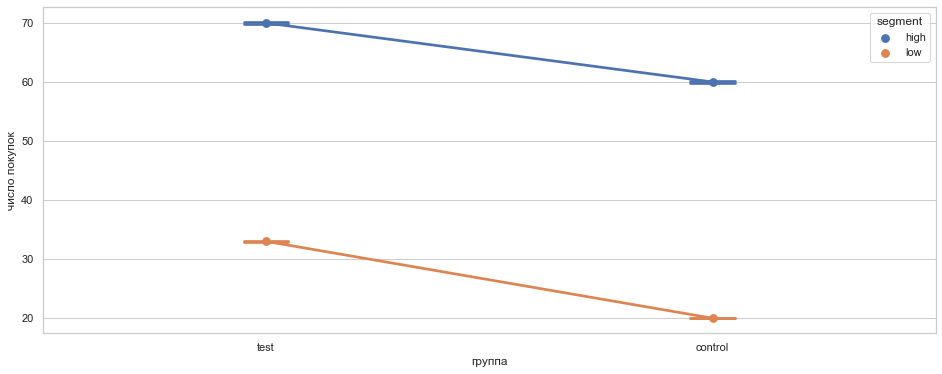

In [40]:
sns.pointplot(x="group", y="events", hue="segment", data=data_2, capsize=0.1)
plt.xlabel('группа')
plt.ylabel('число покупок')
plt.show()

Text(0, 0.5, 'число покупок')

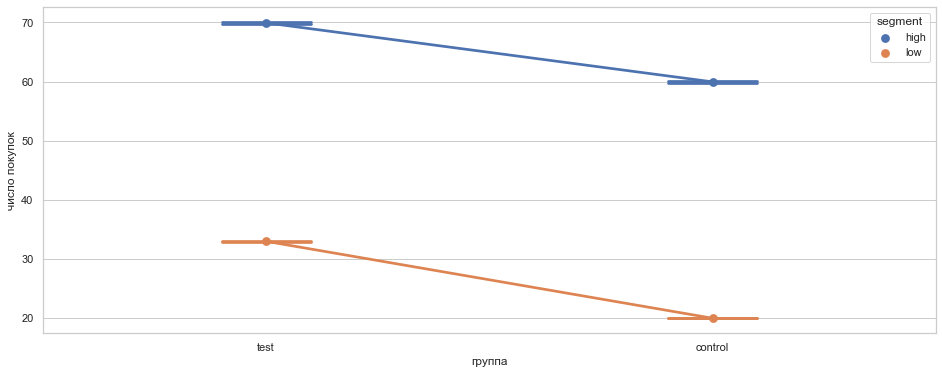

In [41]:
sns.pointplot(x="group", y="events", hue="segment", data=data_2, capsize=0.2)
plt.xlabel('группа')
plt.ylabel('число покупок')

Фактор group оказался 
ЗНАЧИМЫМ
, фактор segment – 
ЗНАЧИМЫМ
, их взаимодействие – 
ЗНАЧИМО
. Судя по графику, для всех групп среднее значение events 
УВЕЛИЧИЛОСЬ
, поэтому решение: 
ВЫКАТЫВАЕМ НОВУЮ ВЕРСИЮ
.
